Estos ejercicios pretenden poner en práctica la habilidad para dibujar gráficos descriptivos comunes, testear múltiples modelos de clasificación de forma rápida y poner en práctica transformadores habituales de la librería __sklearn__.

Las celdas de control están para asegurar que el código se ha ejecutado tal como se ejecutó en mi máquina. El notebook viene ejecutado al completo por defecto.

## Parte 0: Inicialización

En esta parte, simplemente cargamos las librerías que vamos a utilizar y establecemos una semilla para controlar la reproducibilidad del ejercicio.

In [1]:
""" Librerías """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

""" Semilla """

seed = 77

C:\Users\alvar\AppData\Local\Temp\ipykernel_10520\3451365290.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parte 1: Lectura y transformación de datos

En esta parte, principalmente, cargaremos los datos de un repositorio git y realizaremos una breve limpieza de los datos para conseguir un dataframe listo.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/eduardofc/data/main/kddcup99.csv')

print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
df.head()

Número de filas: 561, Número de columnas:10


,duration,protocol_type,service,flag,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',0,0,0.0,0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',0,0,0.0,1,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',0,1,0.0,1,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',0,0,1.0,1,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',0,0,0.0,1,1.0,b'normal.'


Para entender la evolución de las transformaciones que vamos a ir haciendo, generaré algunos de los plot más comunmente utilizados en este tipo de análisis. 

En la siguiente celda, muestro un _countplot_ (_barplot_ de seaborn) para todas las variables del _dataframe_.

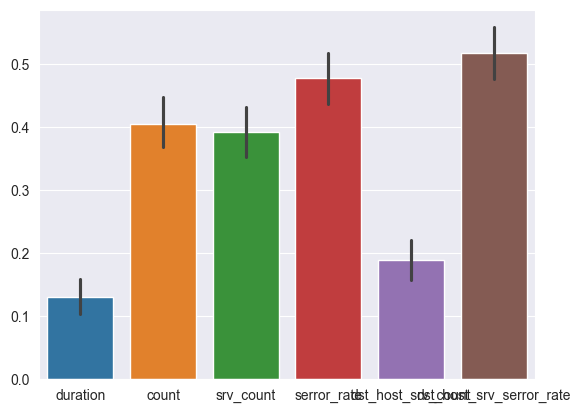

In [3]:
sns.barplot(data=df)
plt.show()

Trabajaremos las variables categóricas con __pandas__. Trataremos de reducir el número de variables categóricas cuando existen demasiadas casuísiticas o cuando existen muy pocos registros en una categoría. 

En esta celda: 
- para la variables _service_, localizamos las 6 categorías más frecuentes y transformamos estas columnas para que ponga _resto_ a todos aquellos registros de estas variables que no están entre las frecuentes, dejando así 7 catgorías en total.
- para la variables _flag_, localizamos las 4 categorías más frecuentes y transformamos estas columnas para que ponga _resto_ a todos aquellos registros de estas variables que no están entre las frecuentes, dejando así 5 catgorías en total.

Finalmente, elimino duplicados.

In [4]:
services = list(df['service'].value_counts().head(6).index)
df['service'] = df['service'].apply(lambda x: 'resto' if x not in services else x)

flags = list(df['flag'].value_counts().head(4).index)
df['flag'] = df['flag'].apply(lambda x: 'resto' if x not in flags else x)

df.drop_duplicates(inplace=True)
df.groupby('labels').size()

labels
b'neptune.'     61
b'normal.'     149
dtype: int64

Celda de control:

In [5]:
assert df.shape == (210, 10)
assert df.groupby('service').size()["resto"] == 44
assert df.groupby('flag').size()['resto'] == 25

## Parte 2: Modelos

En esta parte, testeo distintos modelos con transformaciones.

In [6]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('PER', Perceptron()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))

def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
    
def pca_results(results, names, components):
    df2 = pd.DataFrame(zip(results, names, components), columns=['results', 'names', 'components'])
    
    sns.catplot(data=df2, kind="bar", x="names", y="results", hue="components", height=5, aspect=15/5)
    plt.ylim((0.6, 1.))
    plt.show()
    
cat_cols = ['protocol_type', 'service', 'flag']
num_cols = ['duration', 'count', 'srv_count', 'serror_rate', 
            'dst_host_srv_count', 'dst_host_srv_serror_rate']
target = 'labels'

### Modelos 1 

Realizo un estudio de machine learning con las siguientes características:
* probamos los 5 algoritmos en bucle
* usamos la técnica de validación cruzada StratifiedKFold (5 _folds_) de forma aleatoria.
* entrenamos solo con variables numéricas

En cada iteración del bucle, almaceno el resultado de cada validación cruzada en una variable _results_ y los nombres de cada algoritmo en una variable _names_.

Finalmente, uso *boxplots_algorithms* para dibujar los resultados.

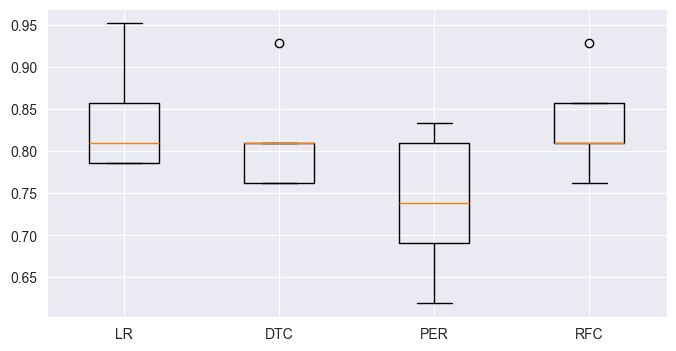

In [7]:
results = []
names = []

y = df[target]
X = df[num_cols]

results = []
names = []
for name, model in models:
    result = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed), scoring="accuracy")
    
    names.append(name)
    results.append(result)

boxplots_algorithms(results, names)

Celda de control:

In [8]:
assert np.round(results[0].mean(),3) == 0.838
assert np.round(results[1].mean(),3) == 0.814
assert np.round(results[2].mean(),3) == 0.738
assert np.round(results[3].mean(),3) == 0.833

### Modelos 2

Realizo un estudio de machine learning con las siguientes características:
* probamos los 5 algoritmos en bucle
* usamos la técnica de validación cruzada KFolds (5 _folds_) aleatoria
* usamos un pipeline que encadena
    * OneHotEncoder simple con las variables categóricas
    * algortimo 
    * _remainder_ tipo _drop_
* Filtramos en X todas las variables**

\*\*Nota: Aunque la opción de _drop_ en el ColumnTransformer haga que solo se entrene con las variables que son usadas en este transformador, vamos a filtrar *X = df[cat_cols+num_cols]* para que podamos explorar la mejora en el siguiente apartado.

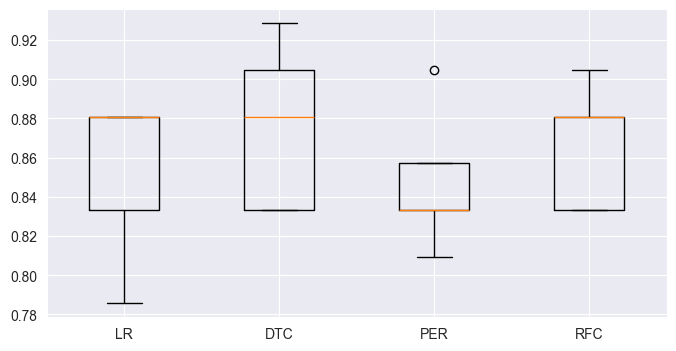

In [9]:
results = []
names = []

# YOUR CODE HERE
y = df[target]
X = df[num_cols + cat_cols]

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols)
], remainder='drop')

results = []
names = []
for name, model in models:
    pl = Pipeline([
        ('column_trans', col_transformer),
        ('model', model)
        ])

    result = cross_val_score(pl, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=seed), scoring="accuracy")
    
    names.append(name)
    results.append(result)

boxplots_algorithms(results, names)

Celda de control:

In [10]:
assert np.round(results[0].mean(),3) == 0.852
assert np.round(results[1].mean(),3) == 0.876
assert np.round(results[2].mean(),3) == 0.848
assert np.round(results[3].mean(),3) == 0.867

### Modelos 3

Realizo un mismo estudio que en Modelos 2, pero esta vez cambiando, la opción _remainder_ a tipo _passthrough_.

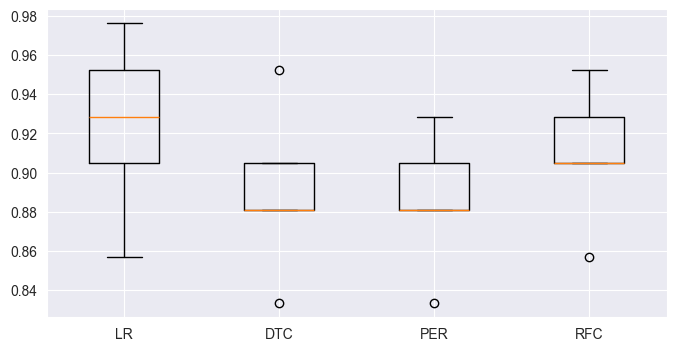

In [11]:
results = []
names = []

# YOUR CODE HERE
y = df[target]
X = df[num_cols + cat_cols]

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols)
], remainder='passthrough')

results = []
names = []
for name, model in models:
    pl = Pipeline([
        ('column_trans', col_transformer),
        ('model', model)
        ])

    result = cross_val_score(pl, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=seed), scoring="accuracy")
    
    names.append(name)
    results.append(result)

boxplots_algorithms(results, names)

Celda de control:

In [12]:
assert np.round(results[0].mean(),3) == 0.924
assert np.round(results[1].mean(),3) == 0.890
assert np.round(results[2].mean(),3) == 0.886
assert np.round(results[3].mean(),3) == 0.910

### Modelos 4

Voy a explorar si puedo mejorar el modelo mediante una transformación de PCA. Usaremos las mismas (X,y). Realizo un estudio de machine learning en bucle con las siguientes características: 
* 5 algoritmos en bucle
* 4 PCA dentro del pipeline y en bucle (dentro del bucle anterior) con _n\_components_=2,3,4,5, para cada algoritmo 
* técnica de validación Folds (5 folds) aleatorio
* pipeline que encadena
     * One-hot-encoder con las variables categoricas, especificando eliminar la primera columna si es binaria
     * PCA
     * algortimo 
* mostramos la matriz de confusión en cada caso

En cada iteración del bucle, almaceno la media de cada resultado de cada validación cruzada en una variable _results_ y los nombres de cada algoritmo en una variable _names_. Además, se guardaré las componentes de cada caso en la lista _components_. 

Finalmente, usaremos la *pca_results* para dibujar los resultados.

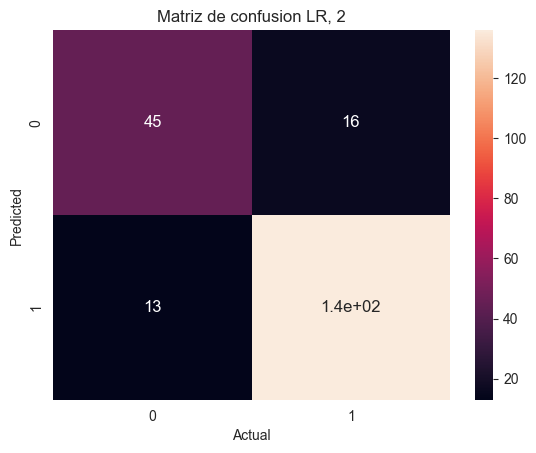

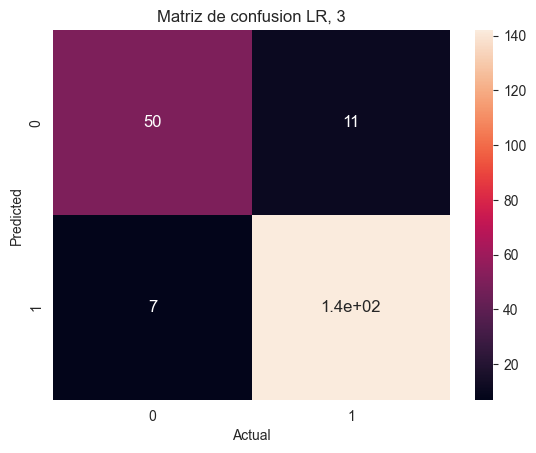

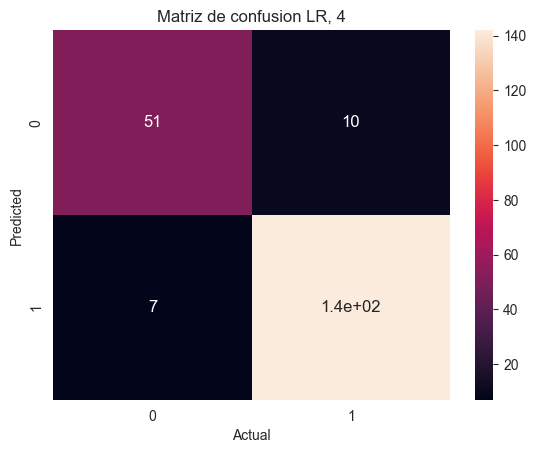

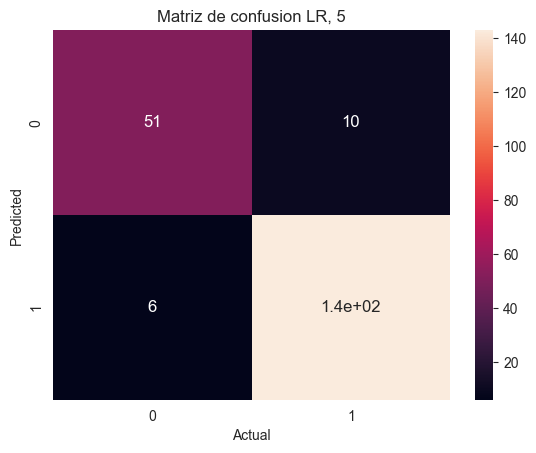

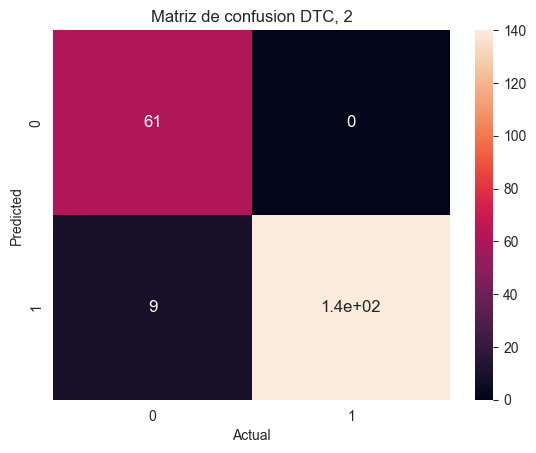

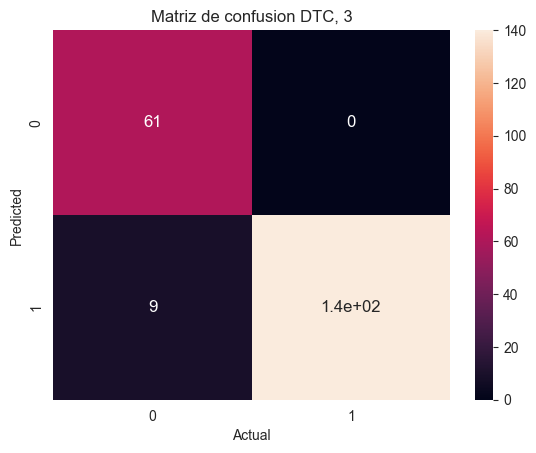

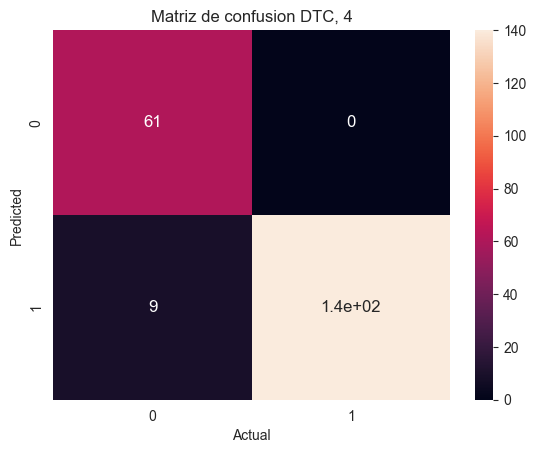

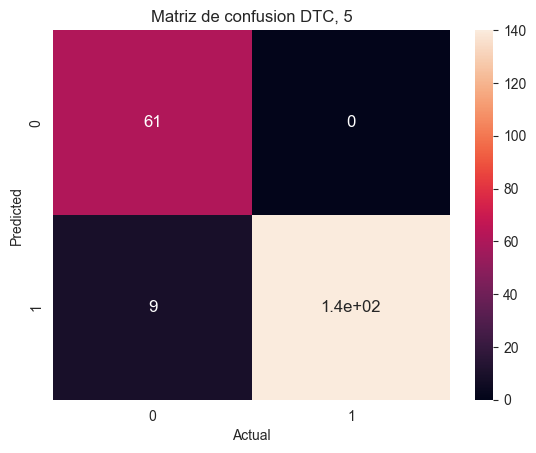

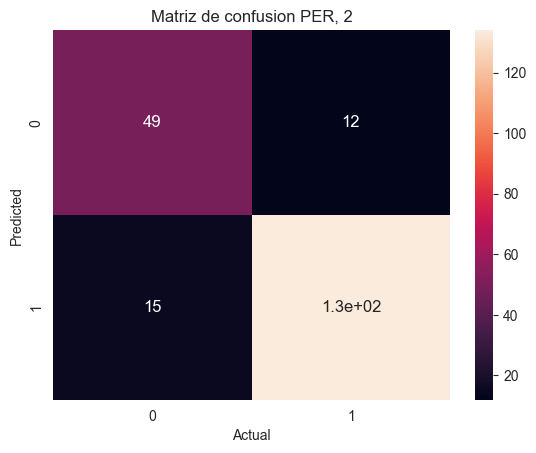

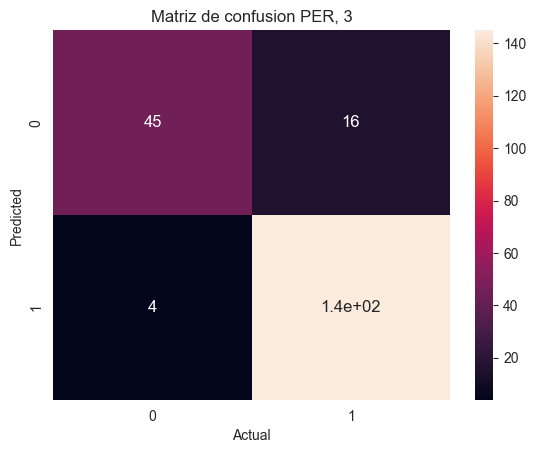

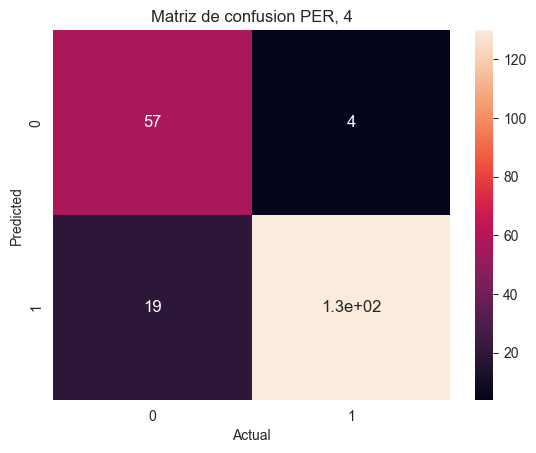

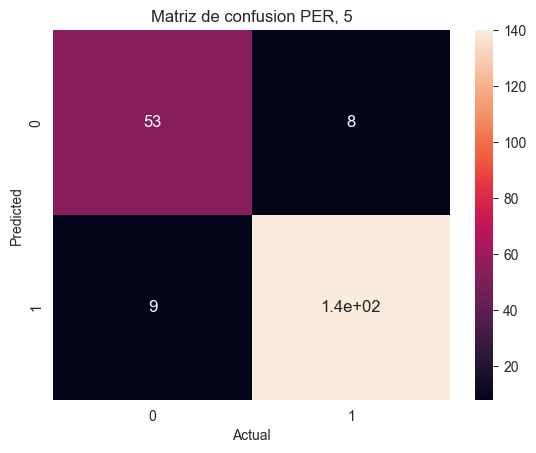

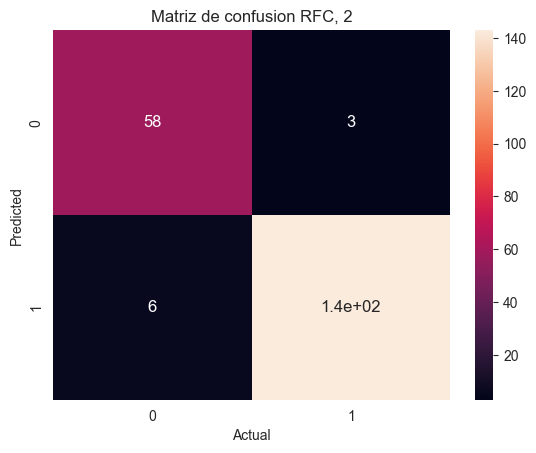

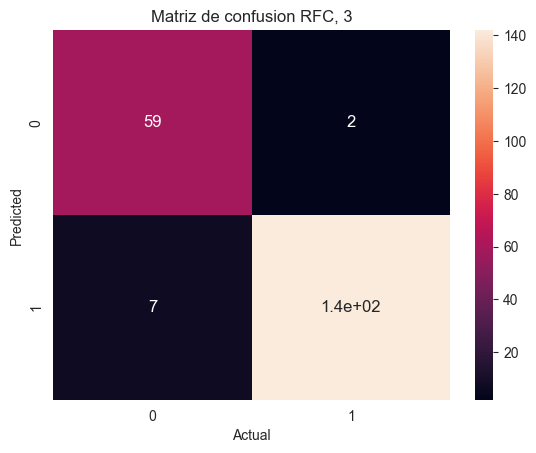

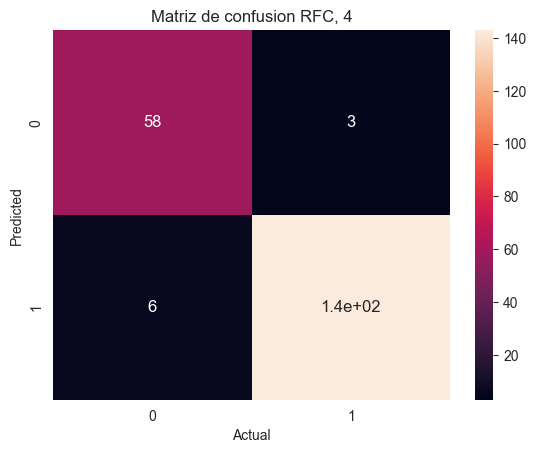

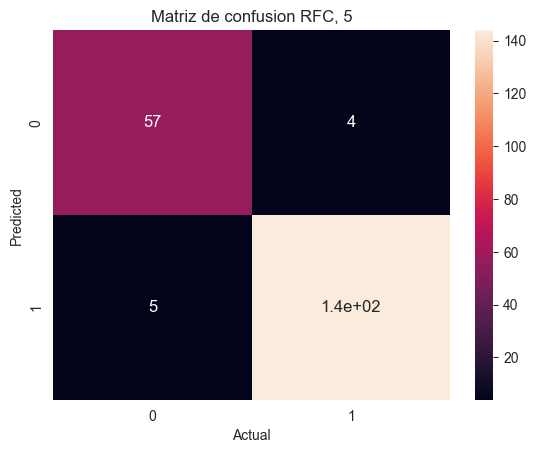

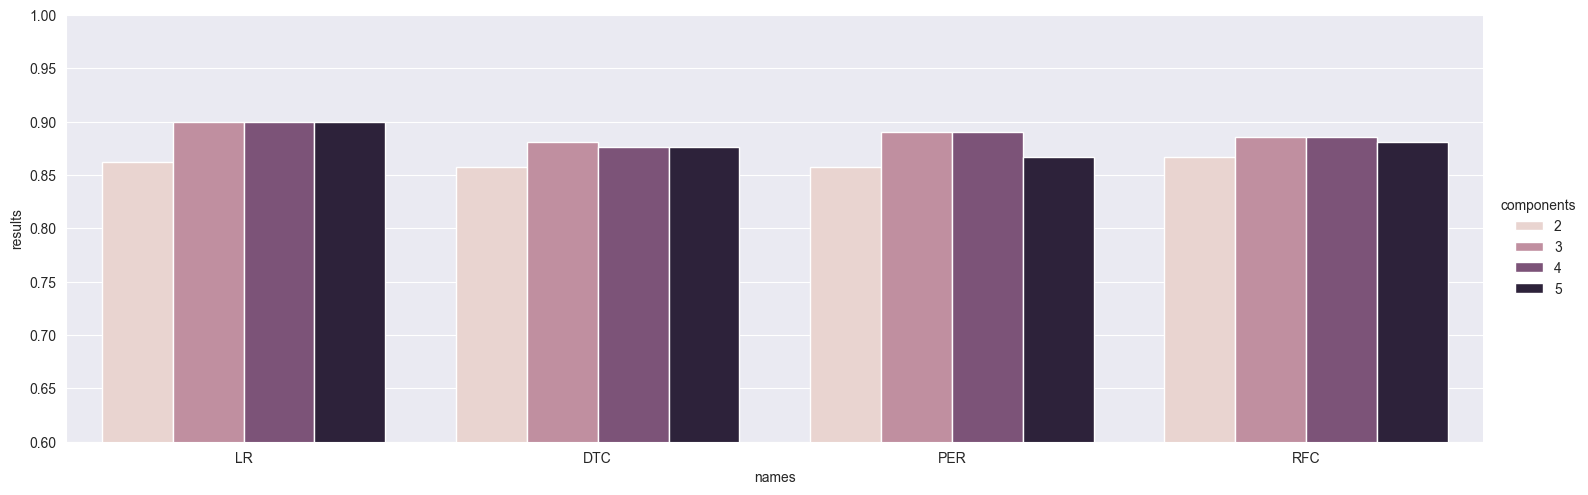

In [13]:
results = []
names = []
components = []

y = df[target]
X = df[num_cols + cat_cols]

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), cat_cols)
], remainder='passthrough')

results = []
names = []
for name, model in models:
    for i in range(2,6):
        pl = Pipeline([
            ('column_trans', col_transformer),
            ('PCA', PCA(n_components=i, random_state=seed)),
            ('model', model)
            ])

        result = cross_val_score(pl, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=seed), scoring="accuracy")
        
        sns.heatmap(confusion_matrix(y_true=y, y_pred=pl.fit(X,y).predict(X)),annot=True, annot_kws={"size": 12})
        plt.title(f'Matriz de confusion {name}, {i}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

        names.append(name)
        results.append(np.mean(result))
        components.append(i)

pca_results(results, names, components)

Celda de control:

In [14]:
assert [np.round(results[x], 3) for x in [1,7,10]] == [0.900, 0.876, 0.890]

### Modelos 5

A partir de aquí, trabajo únicamente con el algoritmo de RandomForestClassifier (sin PCA) y entreno con todas las variables, teniendo en cuenta que las variables categóricas deben transformarse previamente con un OHE.

Separamos primero el _dataset_ en _train_ (80%) y _test_ (20%). Tras ello, solo con el _train_, se hace un ajuste de machine learning con las siguientes características:

* Sin validación cruzada
* Usa un pipeline que encadene 
    * One-hot-encoder con las variables categóricas, especificando eliminar la primera columna si es binaria
    * algoritmo de ML
* Realiza la predicción de _train_ y _test_ por separado para poder mostrar ambas matrices de confusión.

En esta parte, es posible que se haga _overfitting_. Al entrenar con _train_ y evaluar con _test_ después, si las métricas difieren demasiado, podríamos considerar que pueda existir sobreajuste. Teóricamente la validación cruzada ayuda a minimizar este problema; sin embargo, no siempre es así (sobre todo con algoritmos de tipo árbol) y conviene chequear que esto no ocurra. 

Almaceno el _accuracy_ del modelo para los conjuntos _train_ y _test_, y se van a almacenar en las variables _acc_train_ y _acc_test_.

Otra cosa a tener en cuenta es la matriz de confusión. Ésta ofrece siempre el resultado de aplicar el modelo en la clasificación de una forma más legible, lo que ayuda a interpretar mejor el comportamiento de este modelo. Almaceno ambas matrices de confusión en las variables _cm_train_ y _cm_test_.

In [15]:
acc_train = 0
acc_test = 0

cm_train = np.array([[0, 0],[0, 0]])
cm_test = np.array([[0, 0],[0, 0]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), cat_cols)
], remainder='passthrough')

pl = Pipeline([
    ('column_trans', col_transformer),
    ('model', RandomForestClassifier(random_state=seed))
    ])

pl.fit(X_train, y_train)

cm_train = confusion_matrix(y_true=y_train, y_pred=pl.predict(X_train))
cm_test = confusion_matrix(y_true=y_test, y_pred=pl.predict(X_test))
acc_train = pl.score(X_train, y_train)
acc_test = pl.score(X_test, y_test)

print(cm_train)
print(acc_train)

print(cm_test)
print(acc_test)

[[ 47   2]
 [  3 116]]
0.9702380952380952
[[10  2]
 [ 2 28]]
0.9047619047619048


'\nParece que hay overfitting, la precisión de la predicción sobre los datos de \nentrenamiento es muy elevada mientras que al probar sobre el test notamos que\nempeora bastante la predicción.\n'

Parece que hay overfitting, la precisión de la predicción sobre los datos de entrenamiento es muy elevada mientras que al probar sobre el test notamos que empeora bastante la predicción.

Celda de control:

In [16]:
assert np.round(acc_train, 4) == 0.9702
assert np.round(acc_test, 4) == 0.9048
assert (cm_train[0][0], cm_train[0][1], cm_train[1][0], cm_train[1][1]) == (47, 2, 3, 116)
assert (cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]) == (10, 2, 2, 28)

### Modelos 6

En el modelo previo, ya hemos encontrado un ajuste razonable. Ahora toca explorar si existe alguna parametrización que ayude a mejorar esta métrica. 

Voy a separar primero el dataset en train y test. En concreto, separamos el 20% del dataset en el test-set con el que validaremos la calidad real del modelo. Sin embargo, aquí añado el argumento *stratified* dentro del train_test_split para asegurarnos de que hace una correcta partición entre las variables *y*. Mi teoría es que esto ayudará a corregir el overfitting del modelo anterior. 

Tras ello, solo con el _train_, realizo un ajuste de machine learning con las siguientes características:
* mismo algoritmo que en el apartado anterior
* técnica de validación cruzada KFolds (5 folds) 
* pipeline que encadena:
     * OneHotEncoder si son tipo variables tipo _string_, especificando eliminar la primera columna si es binaria
     * algoritmo 
* realizar un tuneado del modelo con GridSearchCV (que almacenaremos en la variable *grid_model*) con los siguientes parámetros del algoritmo:
     * _n\_estimators_, 10, 20 y 30,
     * *max_features*, auto, sqrt y log2,
     * *max_depth*, 10, 20, 50, 70 y 100
     * _criterion_, gini y entropy.
    
Con el mejor de los modelos tuneados, realizo la predicción de _train_ y _test_ para mostrar ambas matrices de confusión y accuracies como en la celda anterior.

In [17]:
acc_train = 0
acc_test = 0

cm_train = np.array([[0, 0],[0, 0]])
cm_test = np.array([[0, 0],[0, 0]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), cat_cols)
], remainder='passthrough')

pl = Pipeline([
    ('column_trans', col_transformer),
    ('model', RandomForestClassifier(random_state=seed))
    ])

parametros = {
    "model__criterion": ['gini', 'entropy'],
    "model__n_estimators": [10,20,30],
    "model__max_depth": [10,20,50,70,100],
    "model__max_features": ['auto', 'sqrt', 'log2']
}

grid_model = GridSearchCV(pl, cv=KFold(n_splits=5, shuffle=True, random_state=seed), scoring='accuracy', param_grid=parametros)
grid_model.fit(X_train,y_train)

cm_train = confusion_matrix(y_true=y_train, y_pred=grid_model.predict(X_train))
cm_test = confusion_matrix(y_true=y_test, y_pred=grid_model.predict(X_test))
acc_train = grid_model.score(X_train, y_train)
acc_test = grid_model.score(X_test, y_test)

print(cm_train)
print(acc_train)

print(cm_test)
print(acc_test)

print(f'Best score: {grid_model.best_score_:.4f}')
grid_model.best_estimator_

[[ 46   3]
 [  5 114]]
0.9523809523809523
[[11  1]
 [ 1 29]]
0.9523809523809523
Best score: 0.8988


Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['protocol_type', 'service',
                                                   'flag'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=77))])

Parece que la introducción del grid search y la opción stratify en train_test_split ayuda a solucionar el overfitting del modelo (probablemente stratify) es lo que ha ayudado más a solucionarlo.

Celda de control:

In [18]:
assert grid_model.cv.random_state == seed
assert np.round(acc_train, 4) == 0.9524
assert np.round(acc_test, 4) == 0.9524
assert (cm_train[0][0], cm_train[0][1], cm_train[1][0], cm_train[1][1]) == (46, 3, 5, 114)
assert (cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]) == (11, 1, 1, 29)
assert len(grid_model.param_grid) == 4
assert len(grid_model.estimator.named_steps) == 2